# Importing all the packages and data!

In [1]:
# Import all the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
import glob as glob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

In [2]:
# Importing our dataset
job_listings = pd.read_csv("clean_dataset.csv")
job_listings.head()

,Unnamed: 0,Title,Company,Description,Salary,City,State,Pincode,Source
0,0,Data Analyst,Seen by Indeed,With one application you can be considered for...,NaN,Seattle,WA,NaN,Indeed
1,1,Business Analyst,Microsoft6,Microsoft Cloud Hardware Infrastructure and En...,NaN,Redmond,WA,NaN,Indeed
2,2,ML Data Associate III,Amazon.com Services LLC46,Basic Qualifications\nBachelors degree or comm...,NaN,Seattle,WA,NaN,Indeed
3,3,Data Analyst,Gupta Media,Gupta Media is looking for a Data Analyst to j...,NaN,Boston,MA,2116,Indeed
4,4,Implementation Specialist / Business Analyst,ScerIS,ScerIS is looking to add experienced and entry...,92500.0,Marlborough,MA,1752,Indeed


In [3]:
job_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28317 entries, 0 to 28316
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   28317 non-null  int64  
 1   Title        28317 non-null  object 
 2   Company      28307 non-null  object 
 3   Description  28317 non-null  object 
 4   Salary       409 non-null    float64
 5   City         28317 non-null  object 
 6   State        28247 non-null  object 
 7   Pincode      11661 non-null  object 
 8   Source       28317 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.9+ MB


In [4]:
# drop useless column
job_listings.drop(['Unnamed: 0'], axis=1, inplace = True)

In [5]:
# Check out dataset
job_listings.head()

,Title,Company,Description,Salary,City,State,Pincode,Source
0,Data Analyst,Seen by Indeed,With one application you can be considered for...,NaN,Seattle,WA,NaN,Indeed
1,Business Analyst,Microsoft6,Microsoft Cloud Hardware Infrastructure and En...,NaN,Redmond,WA,NaN,Indeed
2,ML Data Associate III,Amazon.com Services LLC46,Basic Qualifications\nBachelors degree or comm...,NaN,Seattle,WA,NaN,Indeed
3,Data Analyst,Gupta Media,Gupta Media is looking for a Data Analyst to j...,NaN,Boston,MA,2116,Indeed
4,Implementation Specialist / Business Analyst,ScerIS,ScerIS is looking to add experienced and entry...,92500.0,Marlborough,MA,1752,Indeed


# EDA

Total number of firms with job vacancies in titles of interest 6434


Text(0, 0.5, '# of Jobs')

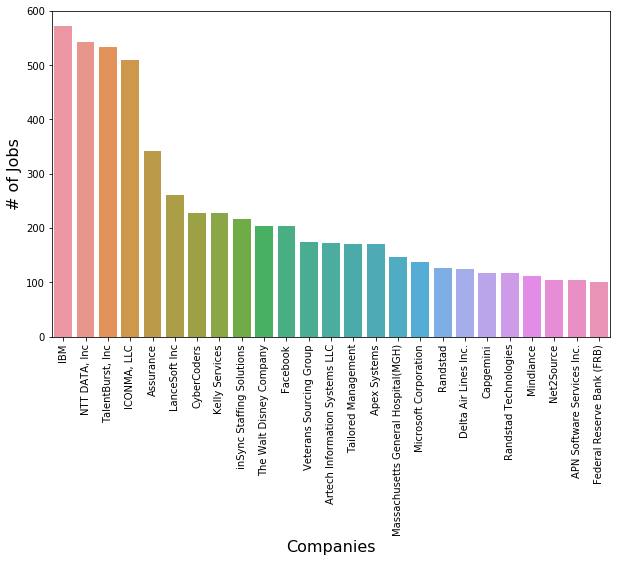

In [6]:
# Now, we are finding total number of companies who require data analysts, business analysts, data scientists & product analysts
total_no_company= job_listings['Company'].nunique()
print('Total number of firms with job vacancies in titles of interest',total_no_company)

# Finding the highest number of vacancy in a company
most_vacancy = job_listings.groupby(['Company'])['Title'].count()
most_vacancy = most_vacancy.reset_index(name='Title')
most_vacancy = most_vacancy.sort_values(['Title'],ascending=False)
most_vacancy = most_vacancy.head(25)

# Plot graph for companies with most job vacancies
fig, ax = plt.subplots(figsize = (10,6))
ax = sns.barplot(x = "Company", y = "Title", data = most_vacancy)    
ax.set_xticklabels(most_vacancy['Company'],rotation = 90)  
ax.set_xlabel('Companies',fontsize = 16, color ='black')
ax.set_ylabel('# of Jobs',fontsize = 16,color ='black') 

Total number of roles across all the firms 16555


Text(0, 0.5, '# of Roles')

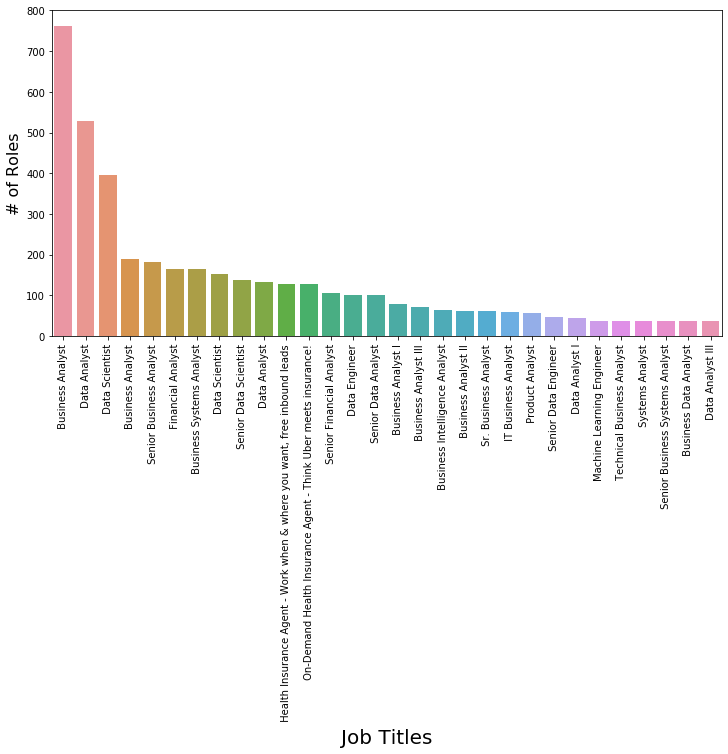

In [7]:
# Finding number of unique titles in our dataset
total_no_roles = job_listings['Title'].nunique()
print('Total number of roles across all the firms',total_no_roles)

# Most offered roles across all the firms
most_offd_roles = job_listings.groupby(['Title'])['Company'].count()   
most_offd_roles = most_offd_roles.reset_index(name='Company')
most_offd_roles = most_offd_roles.sort_values(['Company'],ascending=False)
most_offd_roles = most_offd_roles.head(30)   

# Plot graph for top most offered roles
fig,ax = plt.subplots(figsize = (12,6))
ax = sns.barplot(x = "Title", y = "Company", data = most_offd_roles)    
ax.set_xticklabels(most_offd_roles['Title'],rotation = 90)
ax.set_xlabel('Job Titles',fontsize = 20,color = 'black')
ax.set_ylabel('# of Roles',fontsize = 16,color = 'black')

Total number of states with our job titles 19


Text(0, 0.5, '# of Roles')

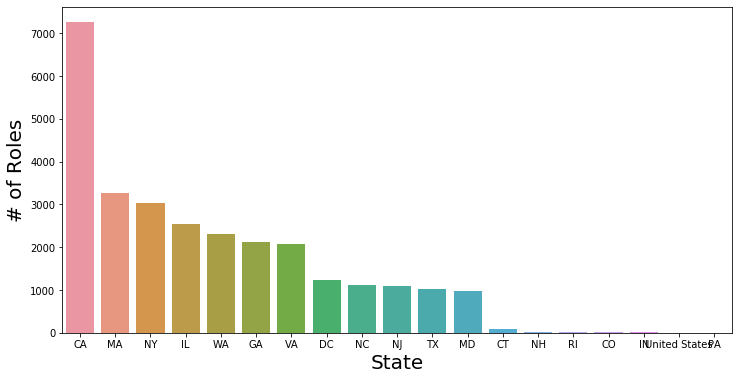

In [8]:
# Finding number of top representing states for our job titles
job_listings_top_states = job_listings.groupby("State").filter(lambda x: len(x) > 5)
total_no_states = job_listings_top_states['State'].nunique()
print('Total number of states with our job titles',total_no_states)

# Plot graph for # of roles per state
fig,ax = plt.subplots(figsize = (12,6))
ax = sns.countplot(x = "State", data = job_listings_top_states,
                      order = job_listings_top_states['State'].value_counts().index)    
ax.set_xlabel('State',fontsize = 20,color = 'black')
ax.set_ylabel('# of Roles',fontsize = 20,color = 'black')

# Frequency of Skills

## Creating our count function

### Entire Data Set

In [9]:
# Create a counter function for the entire dataset
def countkeywords(keyword):
    num = [str(row).lower().count(keyword) for row in job_listings['Description']]
    return keyword,sum(num)

### Data Scientist Role

In [10]:
# Filtering by title "data scientist"
data_science_jobs = job_listings[job_listings.Title.str.lower().str.contains('data scientist')]
print(data_science_jobs.shape)

(2042, 8)


In [11]:
# Create a counter function for the data scientist dataset
def countkeywords_ds(keyword):
    num = [str(row).lower().count(keyword) for row in data_science_jobs['Description']]
    return keyword,sum(num)

### Data Analyst Role

In [12]:
# Filtering by title "data analyst"
data_analyst_jobs = job_listings[job_listings.Title.str.lower().str.contains('data analyst')]
print(data_analyst_jobs.shape)

(2810, 8)


In [13]:
# Create a counter function for the data analyst dataset
def countkeywords_da(keyword):
    num = [str(row).lower().count(keyword) for row in data_analyst_jobs['Description']]
    return keyword,sum(num)

### Product Analyst Role

In [14]:
# Filtering by title "product analyst"
product_analyst_jobs = job_listings[job_listings.Title.str.lower().str.contains('product analyst')]
print(product_analyst_jobs.shape)

(221, 8)


In [15]:
# Create a counter function for the product analyst dataset
def countkeywords_pa(keyword):
    num = [str(row).lower().count(keyword) for row in product_analyst_jobs['Description']]
    return keyword,sum(num)

### Business Analyst Role

In [16]:
# Filtering by title "business analyst"
business_analyst_jobs = job_listings[job_listings.Title.str.lower().str.contains('business analyst')]
print(business_analyst_jobs.shape)

(4359, 8)


In [17]:
# Create a counter function for the business analyst dataset
def countkeywords_ba(keyword):
    num = [str(row).lower().count(keyword) for row in business_analyst_jobs['Description']]
    return keyword,sum(num)

## Technology Skills Count

In [18]:
# Creating a customized list of technology skills
technology_skills_list = ['python', ' r ','sql','java','scala','excel',
                          'aws','hadoop','spark','tableau','sas','c++',
                          'linux','hive','oracle','perl','mysql','matlab',
                          'html','tensorflow','spss','mongodb']

### Entire Datatset

In [19]:
# Checking count
technology_skills = []
for word in technology_skills_list:
     technology_skills.append(countkeywords(str(word)))

In [20]:
# Creating our technology skill column
technology_skill = []

for i in range(len(technology_skills)):
    technology_skill.append(technology_skills[i][0])
    
print(technology_skill)

['python', ' r ', 'sql', 'java', 'scala', 'excel', 'aws', 'hadoop', 'spark', 'tableau', 'sas', 'c++', 'linux', 'hive', 'oracle', 'perl', 'mysql', 'matlab', 'html', 'tensorflow', 'spss', 'mongodb']


In [21]:
# Creating our technology skill frequency column
technology_skill_freq = []

for i in range(len(technology_skills)):
    technology_skill_freq.append(technology_skills[i][1])
    
print(technology_skill_freq)

[8685, 1316, 17179, 4526, 5745, 29221, 6567, 2134, 2731, 5909, 5784, 1110, 1391, 1326, 4938, 1220, 598, 650, 1239, 828, 725, 399]


In [22]:
# Creating our technology skill dataframe
tech_skills_df = {'Technology_Skill':technology_skill,'Frequency':technology_skill_freq}
tech_skills = pd.DataFrame(tech_skills_df)
tech_skills = tech_skills.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

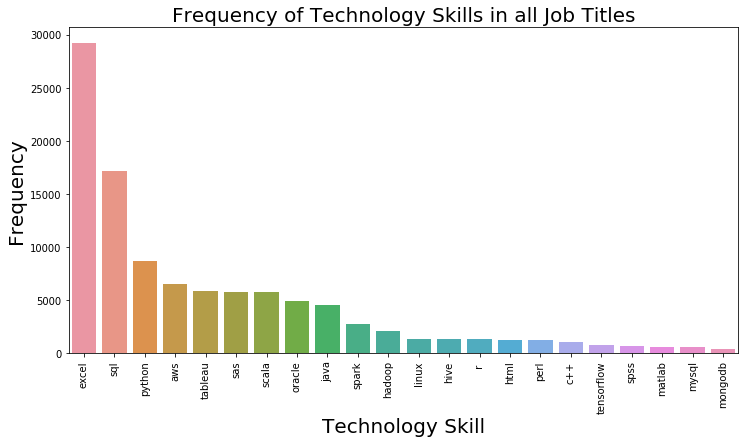

In [23]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Technology_Skill', y='Frequency', data=tech_skills).set_title('Frequency of Technology Skills in all Job Titles',fontsize=20)
ax.set_xticklabels(tech_skills['Technology_Skill'],rotation = 90);
ax.set_xlabel('Technology Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

### Data Scientist Datatset

In [24]:
# Checking count
technology_skills_ds = []
for word in technology_skills_list:
     technology_skills_ds.append(countkeywords_ds(str(word)))

In [25]:
# Creating our technology skill column
technology_skill_ds = []

for i in range(len(technology_skills_ds)):
    technology_skill_ds.append(technology_skills_ds[i][0])
    
print(technology_skill_ds)

['python', ' r ', 'sql', 'java', 'scala', 'excel', 'aws', 'hadoop', 'spark', 'tableau', 'sas', 'c++', 'linux', 'hive', 'oracle', 'perl', 'mysql', 'matlab', 'html', 'tensorflow', 'spss', 'mongodb']


In [26]:
# Creating our technology skill frequency column
technology_skill_freq_ds = []

for i in range(len(technology_skills_ds)):
    technology_skill_freq_ds.append(technology_skills_ds[i][1])
    
print(technology_skill_freq_ds)

[2420, 423, 1748, 596, 758, 1205, 673, 550, 894, 493, 793, 233, 182, 381, 159, 127, 86, 202, 53, 335, 126, 46]


In [27]:
# Creating our technology skill dataframe
tech_skills_df_ds = {'Technology_Skill':technology_skill_ds,'Frequency':technology_skill_freq_ds}
tech_skills_ds = pd.DataFrame(tech_skills_df_ds)
tech_skills_ds = tech_skills_ds.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

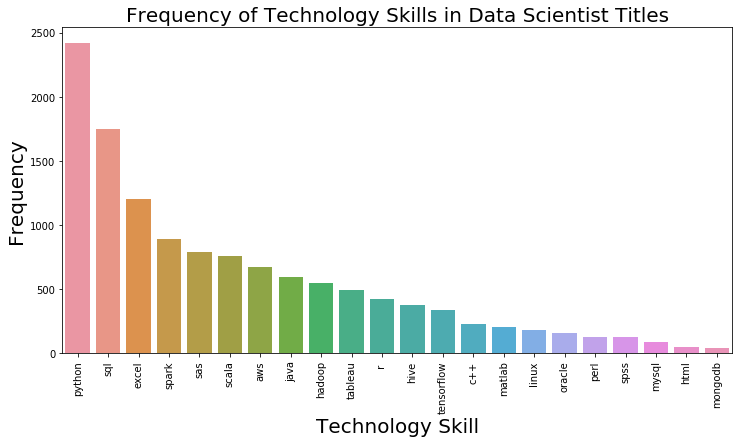

In [28]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Technology_Skill', y='Frequency', data=tech_skills_ds).set_title('Frequency of Technology Skills in Data Scientist Titles',fontsize=20)
ax.set_xticklabels(tech_skills_ds['Technology_Skill'],rotation = 90);
ax.set_xlabel('Technology Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

### Data Analyst Datatset

In [29]:
# Checking count
technology_skills_da = []
for word in technology_skills_list:
     technology_skills_da.append(countkeywords_da(str(word)))

In [30]:
# Creating our technology skill column
technology_skill_da = []

for i in range(len(technology_skills_da)):
    technology_skill_da.append(technology_skills_da[i][0])
    
print(technology_skill_da)

['python', ' r ', 'sql', 'java', 'scala', 'excel', 'aws', 'hadoop', 'spark', 'tableau', 'sas', 'c++', 'linux', 'hive', 'oracle', 'perl', 'mysql', 'matlab', 'html', 'tensorflow', 'spss', 'mongodb']


In [31]:
# Creating our technology skill frequency column
technology_skill_freq_da = []

for i in range(len(technology_skills_da)):
    technology_skill_freq_da.append(technology_skills_da[i][1])
    
print(technology_skill_freq_da)

[1090, 229, 3065, 283, 250, 3309, 346, 187, 116, 1363, 988, 42, 83, 144, 334, 114, 82, 60, 61, 5, 168, 15]


In [32]:
# Creating our technology skill dataframe
tech_skills_df_da = {'Technology_Skill':technology_skill_da,'Frequency':technology_skill_freq_da}
tech_skills_da = pd.DataFrame(tech_skills_df_da)
tech_skills_da = tech_skills_da.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

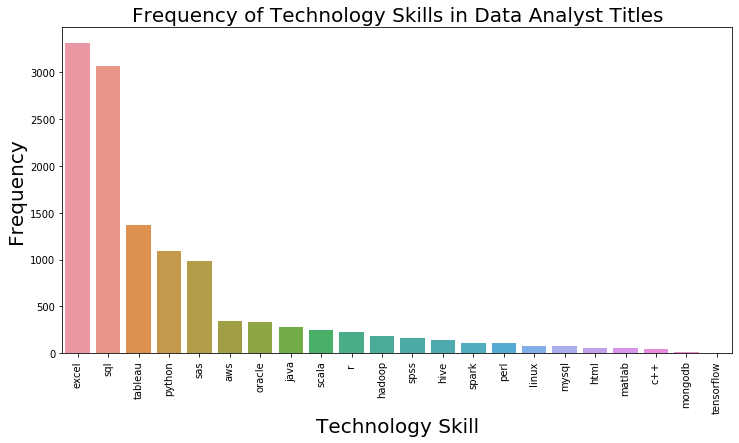

In [33]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Technology_Skill', y='Frequency', data=tech_skills_da).set_title('Frequency of Technology Skills in Data Analyst Titles',fontsize=20)
ax.set_xticklabels(tech_skills_da['Technology_Skill'],rotation = 90);
ax.set_xlabel('Technology Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

### Product Analyst Datatset

In [34]:
# Checking count
technology_skills_pa = []
for word in technology_skills_list:
     technology_skills_pa.append(countkeywords_pa(str(word)))

In [35]:
# Creating our technology skill column
technology_skill_pa = []

for i in range(len(technology_skills_pa)):
    technology_skill_pa.append(technology_skills_pa[i][0])
    
print(technology_skill_pa)

['python', ' r ', 'sql', 'java', 'scala', 'excel', 'aws', 'hadoop', 'spark', 'tableau', 'sas', 'c++', 'linux', 'hive', 'oracle', 'perl', 'mysql', 'matlab', 'html', 'tensorflow', 'spss', 'mongodb']


In [36]:
# Creating our technology skill frequency column
technology_skill_freq_pa = []

for i in range(len(technology_skills_pa)):
    technology_skill_freq_pa.append(technology_skills_pa[i][1])
    
print(technology_skill_freq_pa)

[70, 26, 150, 8, 26, 229, 24, 7, 2, 46, 22, 0, 4, 3, 3, 1, 3, 3, 5, 0, 0, 0]


In [37]:
# Creating our technology skill dataframe
tech_skills_df_pa = {'Technology_Skill':technology_skill_pa,'Frequency':technology_skill_freq_pa}
tech_skills_pa = pd.DataFrame(tech_skills_df_pa)
tech_skills_pa = tech_skills_pa.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

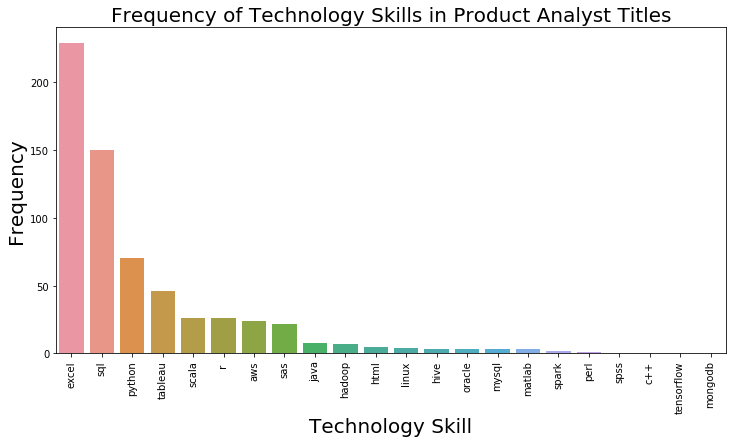

In [38]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Technology_Skill', y='Frequency', data=tech_skills_pa).set_title('Frequency of Technology Skills in Product Analyst Titles',fontsize=20)
ax.set_xticklabels(tech_skills_pa['Technology_Skill'],rotation = 90);
ax.set_xlabel('Technology Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

### Business Analyst Datatset

In [39]:
# Checking count
technology_skills_ba = []
for word in technology_skills_list:
     technology_skills_ba.append(countkeywords_ba(str(word)))

In [40]:
# Creating our technology skill column
technology_skill_ba = []

for i in range(len(technology_skills_ba)):
    technology_skill_ba.append(technology_skills_ba[i][0])
    
print(technology_skill_ba)

['python', ' r ', 'sql', 'java', 'scala', 'excel', 'aws', 'hadoop', 'spark', 'tableau', 'sas', 'c++', 'linux', 'hive', 'oracle', 'perl', 'mysql', 'matlab', 'html', 'tensorflow', 'spss', 'mongodb']


In [41]:
# Creating our technology skill frequency column
technology_skill_freq_ba = []

for i in range(len(technology_skills_ba)):
    technology_skill_freq_ba.append(technology_skills_ba[i][1])
    
print(technology_skill_freq_ba)

[219, 43, 1774, 210, 504, 4582, 528, 32, 26, 545, 449, 31, 23, 37, 703, 106, 22, 8, 102, 0, 13, 2]


In [42]:
# Creating our technology skill dataframe
tech_skills_df_ba = {'Technology_Skill':technology_skill_ba,'Frequency':technology_skill_freq_ba}
tech_skills_ba = pd.DataFrame(tech_skills_df_ba)
tech_skills_ba = tech_skills_ba.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

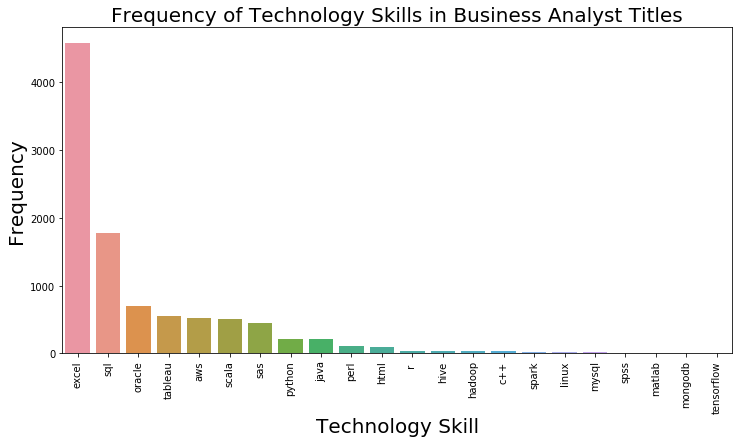

In [43]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Technology_Skill', y='Frequency', data=tech_skills_ba).set_title('Frequency of Technology Skills in Business Analyst Titles',fontsize=20)
ax.set_xticklabels(tech_skills_ba['Technology_Skill'],rotation = 90);
ax.set_xlabel('Technology Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

## Technical Skills Count

In [44]:
# Creating a customized list of technical skills
technical_skills_list = ['big data', 'cloud','dashboard','business problem',
         'predictive model','cluster','data manipulation','experimental design',
         'machine learning','data analysis','data visualization',
         'modeling','statistical analysis','research','deep learning',
         'optimization','decision tree','logistic','random forest',
         'a/b testing','web scraping','neural network','regression']

### Entire Datatset

In [45]:
# Creating technical skills count
technical_skills = []
for word in technical_skills_list:
     technical_skills.append(countkeywords(str(word)))

In [46]:
# Creating our technical skill column
technical_skill = []

for i in range(len(technical_skills)):
    technical_skill.append(technical_skills[i][0])
    
print(technical_skill)

['big data', 'cloud', 'dashboard', 'business problem', 'predictive model', 'cluster', 'data manipulation', 'experimental design', 'machine learning', 'data analysis', 'data visualization', 'modeling', 'statistical analysis', 'research', 'deep learning', 'optimization', 'decision tree', 'logistic', 'random forest', 'a/b testing', 'web scraping', 'neural network', 'regression']


In [47]:
# Creating our technical skill frequency column
technical_skill_freq = []

for i in range(len(technical_skills)):
    technical_skill_freq.append(technical_skills[i][1])
    
print(technical_skill_freq)

[3654, 10841, 6129, 2213, 1566, 1152, 468, 253, 9614, 6889, 3269, 8130, 1500, 23719, 1696, 3550, 282, 2241, 182, 328, 19, 485, 1700]


In [48]:
# Creating our technical skill dataframe
technical_skills_df = {'Technical_Skill':technical_skill,'Frequency':technical_skill_freq}
technical_skills = pd.DataFrame(technical_skills_df)
technical_skills = technical_skills.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

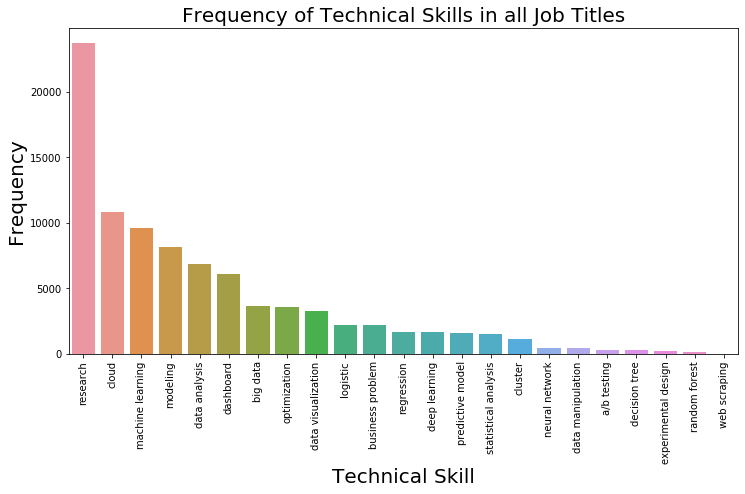

In [49]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Technical_Skill', y='Frequency', data=technical_skills).set_title('Frequency of Technical Skills in all Job Titles',fontsize=20)
ax.set_xticklabels(technical_skills['Technical_Skill'],rotation = 90);
ax.set_xlabel('Technical Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

### Data Scientist Datatset

In [50]:
# Creating technical skills count
technical_skills_ds = []
for word in technical_skills_list:
     technical_skills_ds.append(countkeywords_ds(str(word)))

In [51]:
# Creating our technical skill column
technical_skill_ds = []

for i in range(len(technical_skills_ds)):
    technical_skill_ds.append(technical_skills_ds[i][0])
    
print(technical_skill_ds)

['big data', 'cloud', 'dashboard', 'business problem', 'predictive model', 'cluster', 'data manipulation', 'experimental design', 'machine learning', 'data analysis', 'data visualization', 'modeling', 'statistical analysis', 'research', 'deep learning', 'optimization', 'decision tree', 'logistic', 'random forest', 'a/b testing', 'web scraping', 'neural network', 'regression']


In [52]:
# Creating our technical skill frequency column
technical_skill_freq_ds = []

for i in range(len(technical_skills_ds)):
    technical_skill_freq_ds.append(technical_skills_ds[i][1])
    
print(technical_skill_freq_ds)

[874, 1527, 328, 511, 747, 562, 71, 110, 3739, 789, 563, 1833, 339, 2154, 592, 646, 141, 127, 107, 77, 7, 270, 586]


In [53]:
# Creating our technical skill dataframe
technical_skills_df_ds = {'Technical_Skill':technical_skill_ds,'Frequency':technical_skill_freq_ds}
technical_skills_ds = pd.DataFrame(technical_skills_df_ds)
technical_skills_ds = technical_skills_ds.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

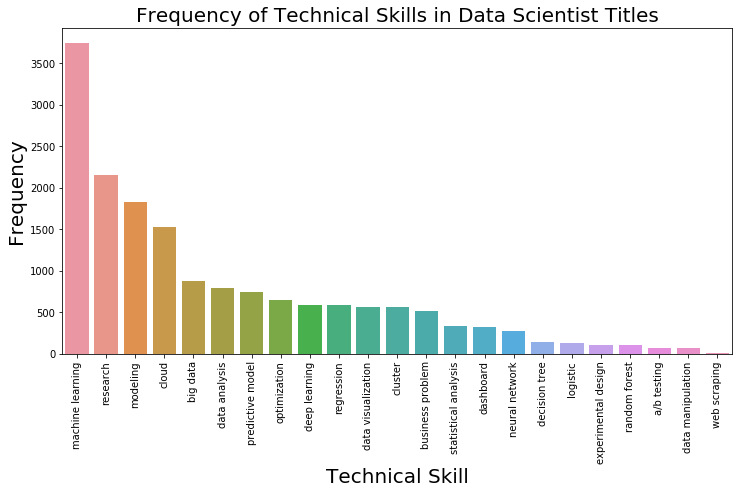

In [54]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Technical_Skill', y='Frequency', data=technical_skills_ds).set_title('Frequency of Technical Skills in Data Scientist Titles',fontsize=20)
ax.set_xticklabels(technical_skills_ds['Technical_Skill'],rotation = 90);
ax.set_xlabel('Technical Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

### Data Analyst Datatset

In [55]:
# Creating technical skills count
technical_skills_da = []
for word in technical_skills_list:
     technical_skills_da.append(countkeywords_da(str(word)))

In [56]:
# Creating our technical skill column
technical_skill_da = []

for i in range(len(technical_skills_da)):
    technical_skill_da.append(technical_skills_da[i][0])
    
print(technical_skill_da)

['big data', 'cloud', 'dashboard', 'business problem', 'predictive model', 'cluster', 'data manipulation', 'experimental design', 'machine learning', 'data analysis', 'data visualization', 'modeling', 'statistical analysis', 'research', 'deep learning', 'optimization', 'decision tree', 'logistic', 'random forest', 'a/b testing', 'web scraping', 'neural network', 'regression']


In [57]:
# Creating our technical skill frequency column
technical_skill_freq_da = []

for i in range(len(technical_skills_da)):
    technical_skill_freq_da.append(technical_skills_da[i][1])
    
print(technical_skill_freq_da)

[266, 401, 1272, 161, 127, 56, 114, 32, 365, 1648, 730, 833, 364, 2107, 23, 290, 14, 112, 7, 49, 2, 19, 182]


In [58]:
# Creating our technical skill dataframe
technical_skills_df_da = {'Technical_Skill':technical_skill_da,'Frequency':technical_skill_freq_da}
technical_skills_da = pd.DataFrame(technical_skills_df_da)
technical_skills_da = technical_skills_da.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

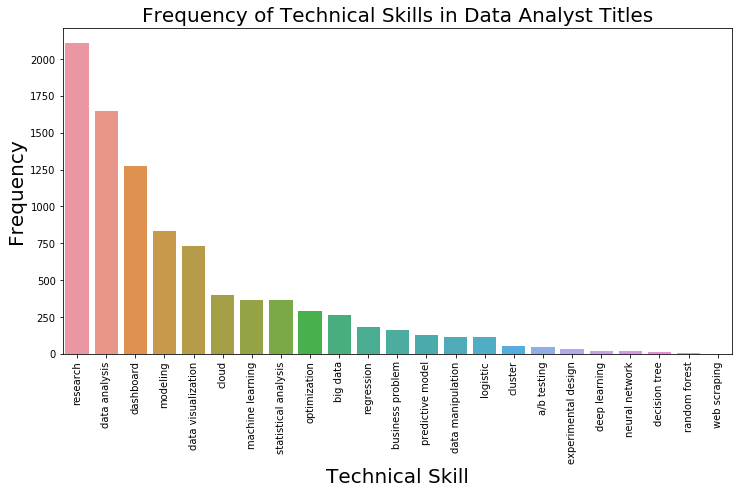

In [59]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Technical_Skill', y='Frequency', data=technical_skills_da).set_title('Frequency of Technical Skills in Data Analyst Titles',fontsize=20)
ax.set_xticklabels(technical_skills_da['Technical_Skill'],rotation = 90);
ax.set_xlabel('Technical Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

### Product Analyst Datatset

In [60]:
# Creating technical skills count
technical_skills_pa = []
for word in technical_skills_list:
     technical_skills_pa.append(countkeywords_pa(str(word)))

In [61]:
# Creating our technical skill column
technical_skill_pa = []

for i in range(len(technical_skills_pa)):
    technical_skill_pa.append(technical_skills_pa[i][0])
    
print(technical_skill_pa)

['big data', 'cloud', 'dashboard', 'business problem', 'predictive model', 'cluster', 'data manipulation', 'experimental design', 'machine learning', 'data analysis', 'data visualization', 'modeling', 'statistical analysis', 'research', 'deep learning', 'optimization', 'decision tree', 'logistic', 'random forest', 'a/b testing', 'web scraping', 'neural network', 'regression']


In [62]:
# Creating our technical skill frequency column
technical_skill_freq_pa = []

for i in range(len(technical_skills_pa)):
    technical_skill_freq_pa.append(technical_skills_pa[i][1])
    
print(technical_skill_freq_pa)

[19, 73, 56, 20, 3, 14, 3, 4, 57, 45, 28, 26, 15, 142, 0, 31, 1, 11, 0, 7, 0, 0, 21]


In [63]:
# Creating our technical skill dataframe
technical_skills_df_pa = {'Technical_Skill':technical_skill_pa,'Frequency':technical_skill_freq_pa}
technical_skills_pa = pd.DataFrame(technical_skills_df_pa)
technical_skills_pa = technical_skills_pa.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

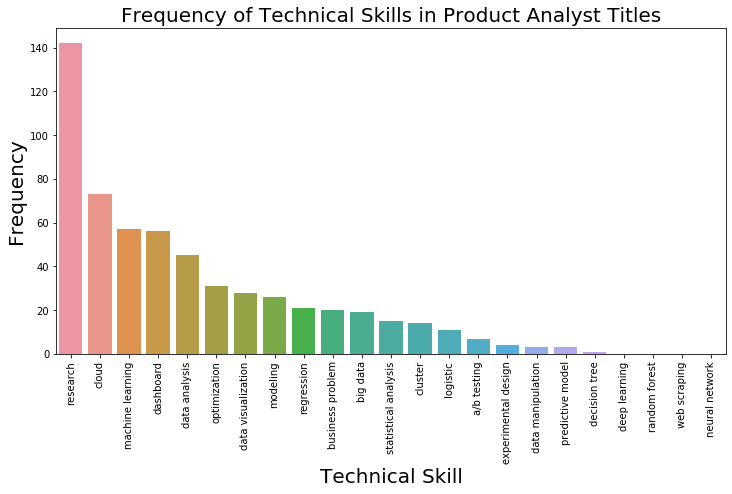

In [64]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Technical_Skill', y='Frequency', data=technical_skills_pa).set_title('Frequency of Technical Skills in Product Analyst Titles',fontsize=20)
ax.set_xticklabels(technical_skills_pa['Technical_Skill'],rotation = 90);
ax.set_xlabel('Technical Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

### Business Analyst Datatset

In [65]:
# Creating technical skills count
technical_skills_ba = []
for word in technical_skills_list:
     technical_skills_ba.append(countkeywords_ba(str(word)))

In [66]:
# Creating our technical skill column
technical_skill_ba = []

for i in range(len(technical_skills_ba)):
    technical_skill_ba.append(technical_skills_ba[i][0])
    
print(technical_skill_ba)

['big data', 'cloud', 'dashboard', 'business problem', 'predictive model', 'cluster', 'data manipulation', 'experimental design', 'machine learning', 'data analysis', 'data visualization', 'modeling', 'statistical analysis', 'research', 'deep learning', 'optimization', 'decision tree', 'logistic', 'random forest', 'a/b testing', 'web scraping', 'neural network', 'regression']


In [67]:
# Creating our technical skill frequency column
technical_skill_freq_ba = []

for i in range(len(technical_skills_ba)):
    technical_skill_freq_ba.append(technical_skills_ba[i][1])
    
print(technical_skill_freq_ba)

[93, 898, 624, 360, 28, 21, 22, 1, 75, 842, 214, 694, 90, 1549, 4, 220, 1, 176, 0, 16, 1, 0, 147]


In [68]:
# Creating our technical skill dataframe
technical_skills_df_ba = {'Technical_Skill':technical_skill_ba,'Frequency':technical_skill_freq_ba}
technical_skills_ba = pd.DataFrame(technical_skills_df_ba)
technical_skills_ba = technical_skills_ba.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

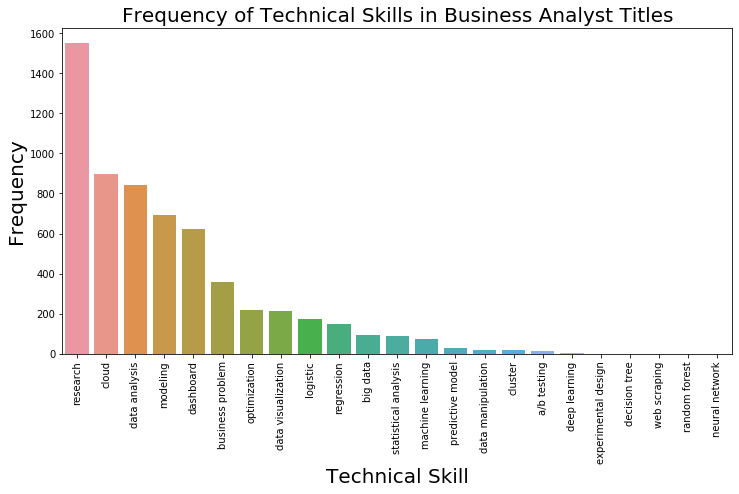

In [69]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Technical_Skill', y='Frequency', data=technical_skills_ba).set_title('Frequency of Technical Skills in Business Analyst Titles',fontsize=20)
ax.set_xticklabels(technical_skills_ba['Technical_Skill'],rotation = 90);
ax.set_xlabel('Technical Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

## Soft Skills Count

In [70]:
# Creating a customized soft skills list
soft_skills_list = ['problem solving','collaborative','independent','curious','leadership',
      'interpersonal skills','communication skills','client management','team build',
      'storytell']

### Entire Dataset

In [71]:
# Creating a soft skill count
soft_skills = []
for word in soft_skills_list:
     soft_skills.append(countkeywords(str(word)))

In [72]:
# Creating our soft skill column
soft_skill = []

for i in range(len(soft_skills)):
    soft_skill.append(soft_skills[i][0])
    
print(soft_skill)

['problem solving', 'collaborative', 'independent', 'curious', 'leadership', 'interpersonal skills', 'communication skills', 'client management', 'team build', 'storytell']


In [73]:
# Creating our soft skill frequency column
soft_skill_freq = []

for i in range(len(soft_skills)):
    soft_skill_freq.append(soft_skills[i][1])
    
print(soft_skill_freq)

[4209, 6050, 9095, 943, 10423, 2825, 11384, 171, 285, 570]


In [74]:
# Creating our soft skill dataframe
soft_skills_df = {'Soft_Skill':soft_skill,'Frequency':soft_skill_freq}
soft_skills = pd.DataFrame(soft_skills_df)
soft_skills = soft_skills.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

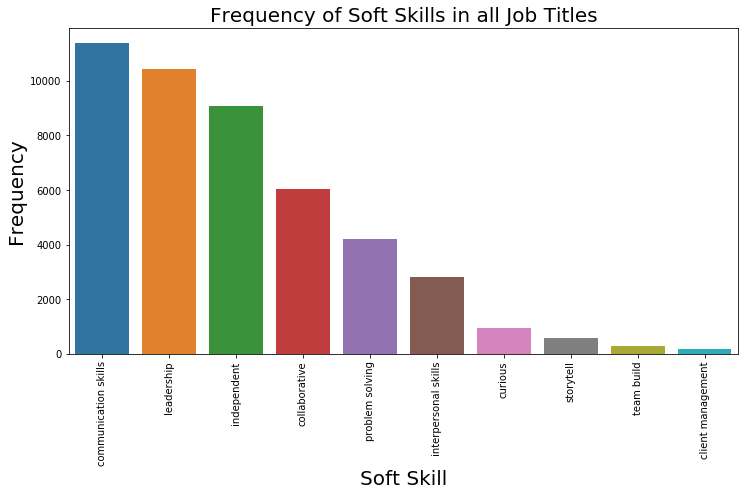

In [75]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Soft_Skill', y='Frequency', data=soft_skills).set_title('Frequency of Soft Skills in all Job Titles',fontsize=20)
ax.set_xticklabels(soft_skills['Soft_Skill'],rotation = 90);
ax.set_xlabel('Soft Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

### Data Scientist Role

In [76]:
# Creating a soft skill count
soft_skills_ds = []
for word in soft_skills_list:
     soft_skills_ds.append(countkeywords_ds(str(word)))

In [77]:
# Creating our soft skill column
soft_skill_ds = []

for i in range(len(soft_skills_ds)):
    soft_skill_ds.append(soft_skills_ds[i][0])
    
print(soft_skill_ds)

['problem solving', 'collaborative', 'independent', 'curious', 'leadership', 'interpersonal skills', 'communication skills', 'client management', 'team build', 'storytell']


In [78]:
# Creating our soft skill frequency column
soft_skill_freq_ds = []

for i in range(len(soft_skills_ds)):
    soft_skill_freq_ds.append(soft_skills_ds[i][1])
    
print(soft_skill_freq_ds)

[262, 514, 441, 106, 768, 104, 648, 6, 26, 80]


In [79]:
# Creating our soft skill dataframe
soft_skills_df_ds = {'Soft_Skill':soft_skill_ds,'Frequency':soft_skill_freq_ds}
soft_skills_ds = pd.DataFrame(soft_skills_df_ds)
soft_skills_ds = soft_skills_ds.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

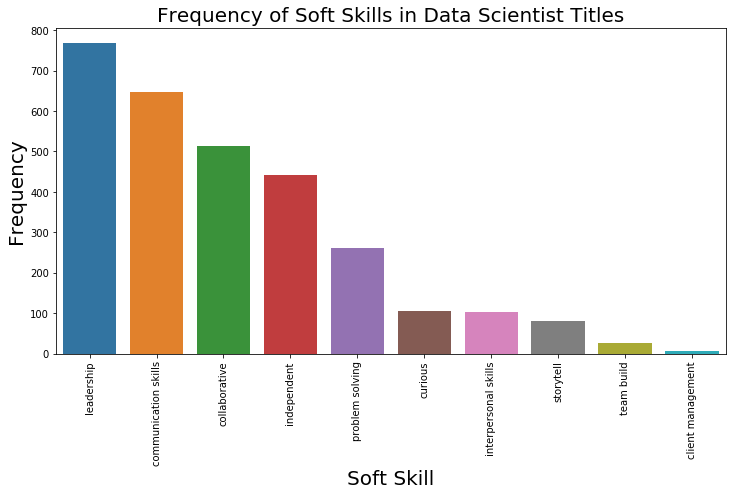

In [80]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Soft_Skill', y='Frequency', data=soft_skills_ds).set_title('Frequency of Soft Skills in Data Scientist Titles',fontsize=20)
ax.set_xticklabels(soft_skills_ds['Soft_Skill'],rotation = 90);
ax.set_xlabel('Soft Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

### Data Analyst Role

In [81]:
# Creating a soft skill count
soft_skills_da = []
for word in soft_skills_list:
     soft_skills_da.append(countkeywords_da(str(word)))

In [82]:
# Creating our soft skill column
soft_skill_da = []

for i in range(len(soft_skills_da)):
    soft_skill_da.append(soft_skills_da[i][0])
    
print(soft_skill_da)

['problem solving', 'collaborative', 'independent', 'curious', 'leadership', 'interpersonal skills', 'communication skills', 'client management', 'team build', 'storytell']


In [83]:
# Creating our soft skill frequency column
soft_skill_freq_da = []

for i in range(len(soft_skills_da)):
    soft_skill_freq_da.append(soft_skills_da[i][1])
    
print(soft_skill_freq_da)

[449, 554, 820, 86, 841, 219, 1110, 20, 19, 43]


In [84]:
# Creating our soft skill dataframe
soft_skills_df_da = {'Soft_Skill':soft_skill_da,'Frequency':soft_skill_freq_da}
soft_skills_da = pd.DataFrame(soft_skills_df_da)
soft_skills_da = soft_skills_da.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

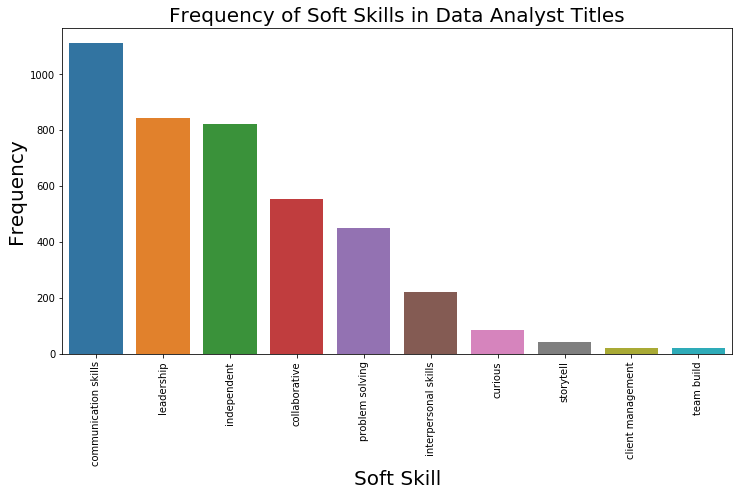

In [85]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Soft_Skill', y='Frequency', data=soft_skills_da).set_title('Frequency of Soft Skills in Data Analyst Titles',fontsize=20)
ax.set_xticklabels(soft_skills_da['Soft_Skill'],rotation = 90);
ax.set_xlabel('Soft Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

### Product Analyst Role

In [86]:
# Creating a soft skill count
soft_skills_pa = []
for word in soft_skills_list:
     soft_skills_pa.append(countkeywords_pa(str(word)))

In [87]:
# Creating our soft skill column
soft_skill_pa = []

for i in range(len(soft_skills_pa)):
    soft_skill_pa.append(soft_skills_pa[i][0])
    
print(soft_skill_pa)

['problem solving', 'collaborative', 'independent', 'curious', 'leadership', 'interpersonal skills', 'communication skills', 'client management', 'team build', 'storytell']


In [88]:
# Creating our soft skill frequency column
soft_skill_freq_pa = []

for i in range(len(soft_skills_pa)):
    soft_skill_freq_pa.append(soft_skills_pa[i][1])
    
print(soft_skill_freq_pa)

[54, 63, 77, 17, 56, 23, 117, 0, 2, 4]


In [89]:
# Creating our soft skill dataframe
soft_skills_df_pa = {'Soft_Skill':soft_skill_pa,'Frequency':soft_skill_freq_pa}
soft_skills_pa = pd.DataFrame(soft_skills_df_pa)
soft_skills_pa = soft_skills_pa.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

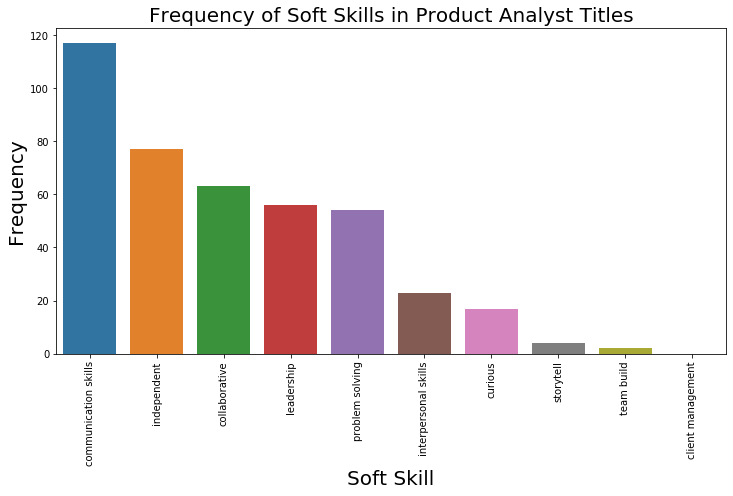

In [90]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Soft_Skill', y='Frequency', data=soft_skills_pa).set_title('Frequency of Soft Skills in Product Analyst Titles',fontsize=20)
ax.set_xticklabels(soft_skills_pa['Soft_Skill'],rotation = 90);
ax.set_xlabel('Soft Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

### Business Analyst Role

In [91]:
# Creating a soft skill count
soft_skills_ba = []
for word in soft_skills_list:
     soft_skills_ba.append(countkeywords_ba(str(word)))

In [92]:
# Creating our soft skill column
soft_skill_ba = []

for i in range(len(soft_skills_ba)):
    soft_skill_ba.append(soft_skills_ba[i][0])
    
print(soft_skill_ba)

['problem solving', 'collaborative', 'independent', 'curious', 'leadership', 'interpersonal skills', 'communication skills', 'client management', 'team build', 'storytell']


In [93]:
# Creating our soft skill frequency column
soft_skill_freq_ba = []

for i in range(len(soft_skills_ba)):
    soft_skill_freq_ba.append(soft_skills_ba[i][1])
    
print(soft_skill_freq_ba)

[764, 716, 1273, 81, 1179, 562, 1950, 21, 32, 14]


In [94]:
# Creating our soft skill dataframe
soft_skills_df_ba = {'Soft_Skill':soft_skill_ba,'Frequency':soft_skill_freq_ba}
soft_skills_ba = pd.DataFrame(soft_skills_df_ba)
soft_skills_ba = soft_skills_ba.sort_values(['Frequency'],ascending=False).reset_index(drop=True)

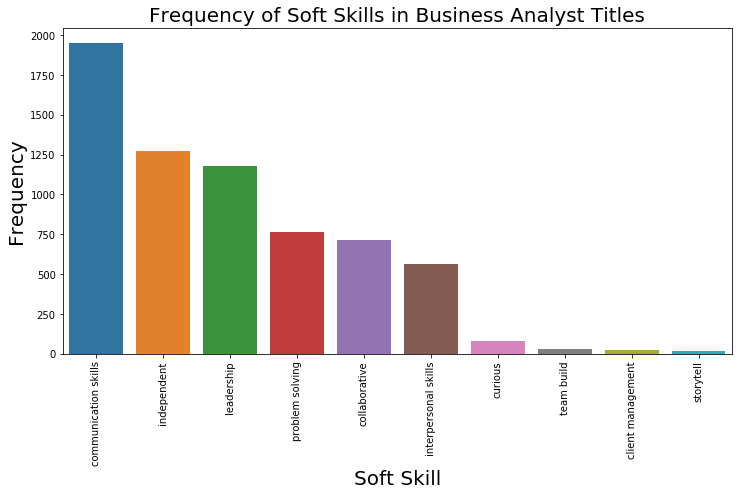

In [95]:
# Let's look at it visually now!
fig,ax = plt.subplots(figsize = (12,6))
sns.barplot(x='Soft_Skill', y='Frequency', data=soft_skills_ba).set_title('Frequency of Soft Skills in Business Analyst Titles',fontsize=20)
ax.set_xticklabels(soft_skills_ba['Soft_Skill'],rotation = 90);
ax.set_xlabel('Soft Skill',fontsize = 20,color = 'black');
ax.set_ylabel('Frequency',fontsize = 20,color = 'black');

# Word Clouds for Different Titles!

## Data Scientist

In [96]:
# Grabbing the text
data_science_text = ''
for x in data_science_jobs['Description'].str.lower():
    data_science_text = data_science_text + x

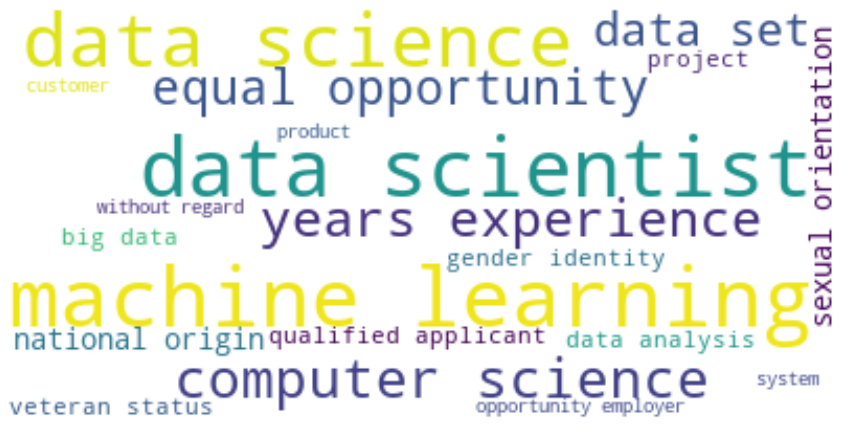

In [97]:
# lower max_font_size, change the maximum number of word and lighten the background:
plt.figure(figsize=(15,8))
wordcloud = WordCloud(max_font_size=40, max_words=20, background_color="white").generate(data_science_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Data Analyst

In [98]:
# Grabbing the text
data_analyst_text = ''
for x in data_analyst_jobs['Description'].str.lower():
    data_analyst_text = data_analyst_text + x

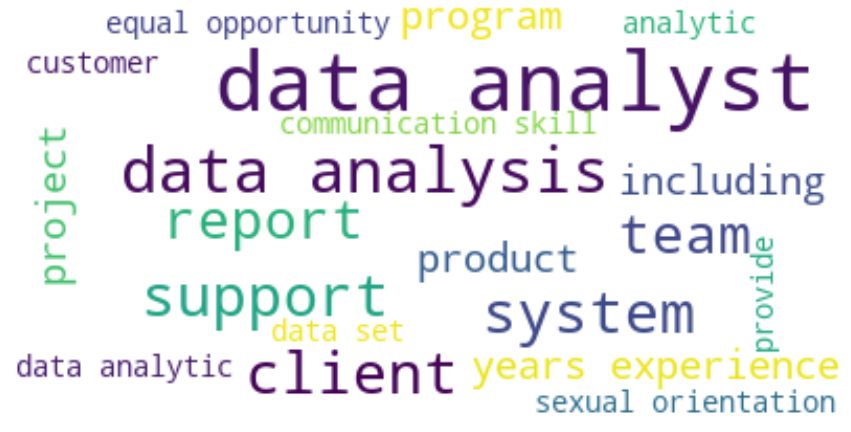

In [99]:
# lower max_font_size, change the maximum number of word and lighten the background:
plt.figure(figsize=(15,8))
wordcloud = WordCloud(max_font_size=40, max_words=20, background_color="white").generate(data_analyst_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Product Analyst

In [100]:
# Grabbing the text
product_analyst_text = ''
for x in product_analyst_jobs['Description'].str.lower():
    product_analyst_text = product_analyst_text + x

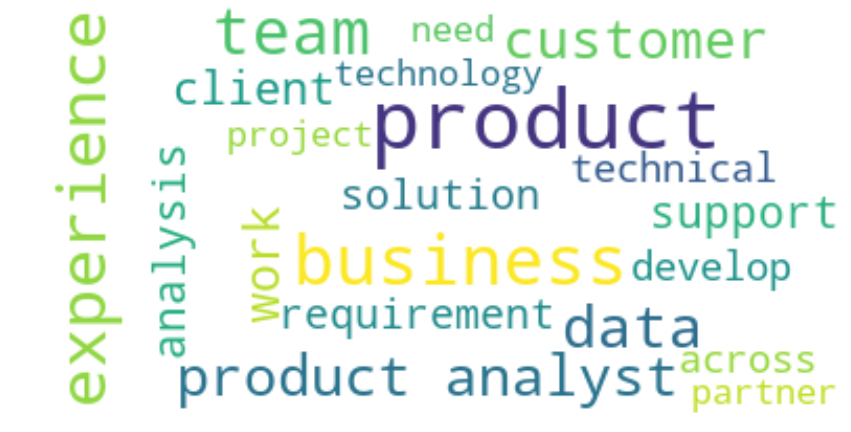

In [101]:
# lower max_font_size, change the maximum number of word and lighten the background:
plt.figure(figsize=(15,8))
wordcloud = WordCloud(max_font_size=40, max_words=20, background_color="white").generate(product_analyst_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Business Analyst

In [102]:
# Grabbing the text
business_analyst_text = ''
for x in business_analyst_jobs['Description'].str.lower():
    business_analyst_text = business_analyst_text + x

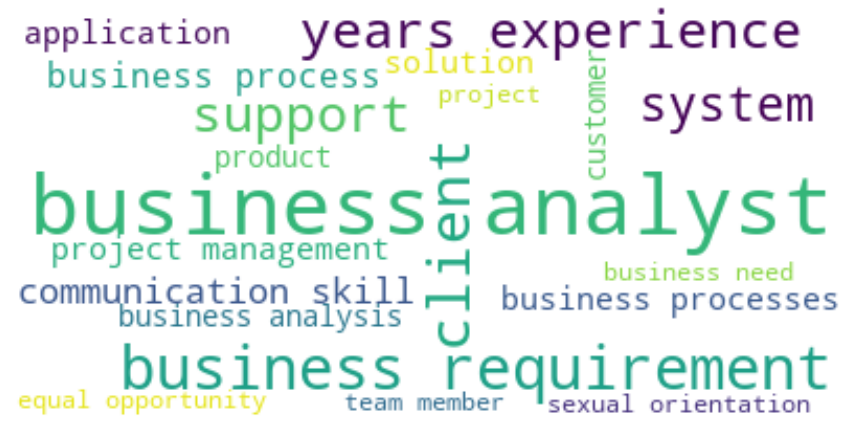

In [103]:
# lower max_font_size, change the maximum number of word and lighten the background:
plt.figure(figsize=(15,8))
wordcloud = WordCloud(max_font_size=40, max_words=20, background_color="white").generate(business_analyst_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()